# 2-7. 프로젝트: ResNet Ablation Study


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0) 라이브러리 버전 확인하기

사용할 라이브러리 버전을 둘러봅시다.

<br>

**LMS 버전**

```
2.6.0
1.21.4
```

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete7H7HB0/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [ ]:
# 클래스 갯수 확인
ds_info.features["label"].num_classes

2

In [ ]:
# 클래그 레이블 이름 확인
ds_info.features["label"].names

['cat', 'dog']

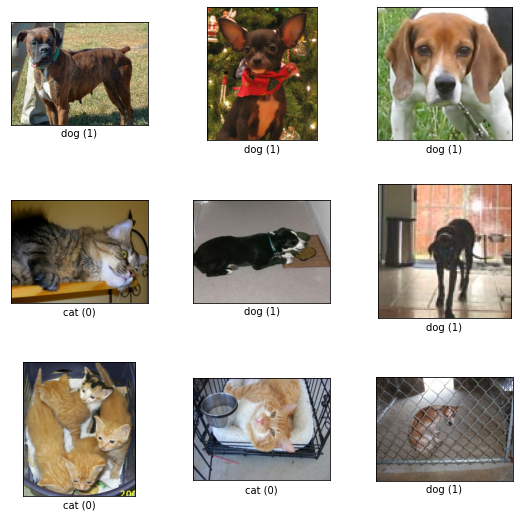

In [ ]:
# train 데이터 셋 확인
fig = tfds.show_examples(ds_train, ds_info)

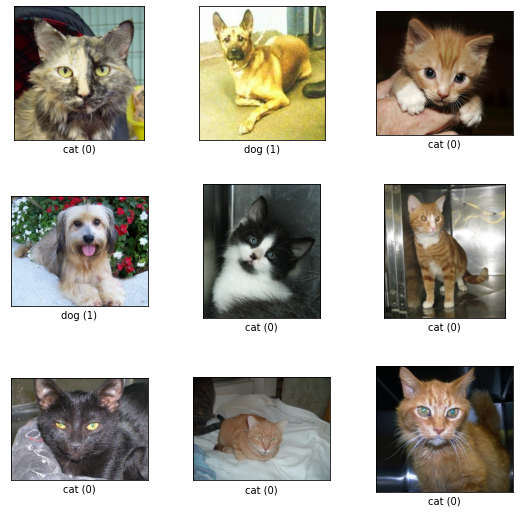

In [ ]:
# test 데이터 셋 확인
fig = tfds.show_examples(ds_test, ds_info)

## Data Normalization

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    # ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 1) ResNet 기본 블록 구성하기

이제 실전으로 돌아와서 **ResNet-34**와 **ResNet-50** 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

<br>

- [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)
- [빛과 같은 카이밍허님의 깃헙](https://github.com/KaimingHe/deep-residual-networks)

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

<br>

> Q1. ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.<br><br>
ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

<br>

위의 퀴즈의 답을 어느 정도 스스로 찾아내셨다면 ResNet의 기본 블록, 또는 Residual 블록(residual block)이 어떻게 구성되어야 할지 감이 오셨을 것입니다. Learning by Doing 이라고 하죠! 이번에는 ResNet의 블록을 직접 만들어 봅시다! 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 됩니다.

<br>

우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇 번의 경험이 있습니다.<br>
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.

<br>

그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.

<br>

하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현 방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다.

1-1) **residaul block**과 **bottleneck** 둘 다 들어가는 **`3x3, 64`** 컨볼루션을 만든다.



In [ ]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               regularizer,
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',  # Xavier Initialization를 Kaiming He가 개선한 것
                            kernel_regularizer=keras.regularizers.l2(regularizer),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

1-2) Resnet 블록 생성

- `regularizer` : resnet 50 이상에서는 `1e-4`, resnet 50 이하에서는 `1e-3`을 사용한다.

In [ ]:
def build_resnet_block(input_layer,                   
                       num_cnn=3, 
                       channel=64, 
                       block_num=0,
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50 이상의 모델
    if is_50:
        regularizer=1e-4
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), regularizer, strides=2, activation=None)
                x = conv_block(x, channel, (1,1), regularizer,  strides=2)
                x = conv_block(x, channel, (3,3),  regularizer)
                x = conv_block(x, channel*4, (1,1), regularizer, activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1),  regularizer)
                x = conv_block(x, channel, (3,3),  regularizer)
                x = conv_block(x, channel*4, (1,1), regularizer, activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34 이하의 모델
    else:
        regularizer=1e-3
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), regularizer, strides=2, activation=None)
                x = conv_block(x, channel, (3,3), regularizer, strides=2)
                x = conv_block(x, channel, (3,3), regularizer, activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3), regularizer)
                x = conv_block(x, channel, (3,3), regularizer, activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    return x

In [ ]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=2, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.

    # first layer
    if is_50:
        regularizer=1e-4
        x = conv_block(input_layer, 64, (7,7), regularizer, strides=2)
    else:
        regularizer=1e-3
        x = conv_block(input_layer, 64, (7,7), regularizer, strides=2)

    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x) # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다. 
    
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)): 
        x = build_resnet_block(x, num_cnn=num_cnn, channel=channel, block_num=block_num, is_50=is_50) 
        x = keras.layers.GlobalAveragePooling2D()(x) 
        x = keras.layers.Dense(num_classes, activation=activation, kernel_initializer='he_normal' )(x) 
        name ='' 
        
        if is_50 == False: 
            name = 'Resnet-34' 
        else: 
            name = 'Resnet-50' 
        
        model = keras.Model(inputs=input_layer, outputs=x, name=name) 
        
        return model

# 2) ResNet-34, ResNet-50 Complete Model

<br>

> **ResNet 모델 구현 시** `Sequential API`나 `Subclass API`를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 <u>`model.summary()` 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다.</u> 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 **`Functional API`** 를 구성하는 방식을 사용할 것을 권합니다.



**ResNet-34**

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 `build_resnet()`를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

<br>

다음의 코드를 실행하면,



In [ ]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False) 
resnet_34.summary()

Model: "Resnet-34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][

**ResNet-50**

위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

In [ ]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "Resnet-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0

<u>ResNet-50은 구현마다 약간씩 다르게 나올 수 있습니다.</u> 왜냐하면 Residual 블록의 Batch Normalization과 ReLU 레이어의 위치가 논문에 명시되지 않았기 때문이죠!

<br>

하지만 ResNet을 고안한 4인방은 이에 대해 또 한번 논문을 씁니다. Residual 블록에 대해서 자세하게 씁니다. 이 논문을 읽어보면 오리지널 ResNet-50에 대한 힌트가 약.간. 있을 수도 있습니다~!

<br>

- [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)


# 3) 일반 네트워크(plain network) 만들기

<br>

**블록 코드 수정하기**

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

<br>

**전체 함수 코드 수정하기**

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 `build_plainnet()`를 만들어 보세요. 이때 입력 이미지의 크기는 `(224, 224, 3)`으로 해주세요.

In [ ]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        regularizer=1e-4
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), regularizer, strides=2)
                x = conv_block(x, channel, (3,3), regularizer)
                x = conv_block(x, channel*4, (1,1), regularizer)
            else:
                x = conv_block(x, channel, (1,1), regularizer)
                x = conv_block(x, channel, (3,3), regularizer)
                x = conv_block(x, channel*4, (1,1), regularizer)
    
    # plain-34
    else:
        regularizer=1e-3
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), regularizer, strides=2)
                x = conv_block(x, channel, (3,3), regularizer)
            else:
                x = conv_block(x, channel, (3,3), regularizer)
                x = conv_block(x, channel, (3,3), regularizer)

    return x

In [ ]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=2,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    if is_50:
        regularizer=1e-4
        x = conv_block(input_layer, 64, (7,7), regularizer, strides=2)
    else:
        regularizer=1e-3
        x = conv_block(input_layer, 64, (7,7), regularizer, strides=2)

    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [ ]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_18 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 56, 56, 64)        369

In [ ]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_51 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_51 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_52 (Conv2D)          (None, 56, 56, 64)        416

In [ ]:
del resnet_34
del resnet_50
del plain_34
del plain_50

# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

<br>


**Ablation Study**

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

<br>

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 `tensorflow-datasets`에서 제공하는 `cats_vs_dogs` 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

<br><br>

**시각화**

학습을 통해 만들어진 `history`를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

<br><br>

**추가 실험**

시간이 남으면 아래 카탈로그를 보고, `tensorflow-datasets`의 지원하는 다른 데이터셋에 실험을 해봅시다.

- [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)

- **ResNet 논문**에서처럼 배치사이즈를 256으로 했더니, RAM 초과로 세션이 다운됨.
- 데이터 셋도 작아서 배치사이즈를 `16`으로 설정하고 진행함

In [ ]:
BATCH_SIZE = 16
EPOCH = 50

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

## ResNet-34

In [ ]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=1e-5),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/50
1163/1163 [==============================] - 60s 39ms/step - loss: 1.5069 - accuracy: 0.6388 - val_loss: 1.5251 - val_accuracy: 0.6096
Epoch 2/50
1163/1163 [==============================] - 46s 40ms/step - loss: 1.4234 - accuracy: 0.6820 - val_loss: 1.4492 - val_accuracy: 0.6416
Epoch 3/50
1163/1163 [==============================] - 45s 39ms/step - loss: 1.3551 - accuracy: 0.7153 - val_loss: 1.3781 - val_accuracy: 0.6818
Epoch 4/50
1163/1163 [==============================] - 47s 40ms/step - loss: 1.2986 - accuracy: 0.7334 - val_loss: 1.2795 - val_accuracy: 0.7405
Epoch 5/50
1163/1163 [==============================] - 45s 38ms/step - loss: 1.2480 - accuracy: 0.7492 - val_loss: 1.4918 - val_accuracy: 0.5988
Epoch 6/50
1163/1163 [==============================] - 45s 39ms/step - loss: 1.1965 - accuracy: 0.7604 - val_loss: 1.3028 - val_accuracy: 0.6682
Epoch 7/50
1163/1163 [==============================] - 45s 39ms/step - loss: 1.1460 - accuracy: 0.7818 - val_loss: 1.3864 -

In [ ]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_resnet_34.csv', index=False)

## ResNet-50

In [25]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=1e-5),
    metrics=['accuracy']
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/50
1163/1163 [==============================] - 38s 29ms/step - loss: 0.9311 - accuracy: 0.6262 - val_loss: 1.0149 - val_accuracy: 0.5656
Epoch 2/50
1163/1163 [==============================] - 34s 29ms/step - loss: 0.8925 - accuracy: 0.6702 - val_loss: 1.0217 - val_accuracy: 0.5818
Epoch 3/50
1163/1163 [==============================] - 34s 29ms/step - loss: 0.8623 - accuracy: 0.6992 - val_loss: 1.4711 - val_accuracy: 0.5287
Epoch 4/50
1163/1163 [==============================] - 34s 29ms/step - loss: 0.8361 - accuracy: 0.7225 - val_loss: 1.0268 - val_accuracy: 0.6300
Epoch 5/50
1163/1163 [==============================] - 34s 29ms/step - loss: 0.8090 - accuracy: 0.7430 - val_loss: 0.9130 - val_accuracy: 0.6758
Epoch 6/50
1163/1163 [==============================] - 34s 29ms/step - loss: 0.7839 - accuracy: 0.7615 - val_loss: 0.7895 - val_accuracy: 0.7573
Epoch 7/50
1163/1163 [==============================] - 34s 29ms/step - loss: 0.7564 - accuracy: 0.7778 - val_loss: 0.8960 -

In [26]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })
df_resnet_50.to_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_resnet_50.csv', index=False)

## Plain-34

In [27]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1163/1163 [==============================] - 132s 107ms/step - loss: 3.8214 - accuracy: 0.5044 - val_loss: 1.6615 - val_accuracy: 0.5287
Epoch 2/50
1163/1163 [==============================] - 126s 108ms/step - loss: 1.3787 - accuracy: 0.5054 - val_loss: 1.0776 - val_accuracy: 0.4918
Epoch 3/50
1163/1163 [==============================] - 126s 109ms/step - loss: 1.1510 - accuracy: 0.4983 - val_loss: 0.9787 - val_accuracy: 0.4935
Epoch 4/50
1163/1163 [==============================] - 126s 108ms/step - loss: 0.8654 - accuracy: 0.5055 - val_loss: 32.8757 - val_accuracy: 0.5147
Epoch 5/50
1163/1163 [==============================] - 126s 108ms/step - loss: 0.8987 - accuracy: 0.5052 - val_loss: 1.4335 - val_accuracy: 0.4862
Epoch 6/50
1163/1163 [==============================] - 127s 109ms/step - loss: 0.8902 - accuracy: 0.5022 - val_loss: 0.8883 - val_accuracy: 0.4890
Epoch 7/50
1163/1163 [==============================] - 126s 109ms/step - loss: 0.8586 - accuracy: 0.5037 - val_loss: 0.83

In [28]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_plain_34.csv', index=False)

## Plain-50

In [29]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1163/1163 [==============================] - 197s 161ms/step - loss: 3.1033 - accuracy: 0.5177 - val_loss: 2.0142 - val_accuracy: 0.4892
Epoch 2/50
1163/1163 [==============================] - 186s 160ms/step - loss: 1.7459 - accuracy: 0.5012 - val_loss: 1.4913 - val_accuracy: 0.4920
Epoch 3/50
1163/1163 [==============================] - 186s 160ms/step - loss: 1.4298 - accuracy: 0.5108 - val_loss: 1.3281 - val_accuracy: 0.5153
Epoch 4/50
1163/1163 [==============================] - 186s 160ms/step - loss: 1.2055 - accuracy: 0.4987 - val_loss: 1.0968 - val_accuracy: 0.4888
Epoch 5/50
1163/1163 [==============================] - 186s 160ms/step - loss: 1.0663 - accuracy: 0.5073 - val_loss: 11.4167 - val_accuracy: 0.4892
Epoch 6/50
1163/1163 [==============================] - 186s 160ms/step - loss: 0.9973 - accuracy: 0.5070 - val_loss: 0.9502 - val_accuracy: 0.4864
Epoch 7/50
1163/1163 [==============================] - 186s 160ms/step - loss: 0.8979 - accuracy: 0.5035 - val_loss: 0.84

In [30]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_plain_50.csv', index=False)

# 모델학습 결과 비교

In [31]:
history_resnet_34 = pd.read_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_resnet_34.csv')
history_resnet_50 = pd.read_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_resnet_50.csv')
history_plain_34 = pd.read_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_plain_34.csv')
history_plain_50 = pd.read_csv('/content/drive/MyDrive/아이펠/GOING DEEPER/data/history_plain_50.csv')

## ResNet-34와 Plain-34 비교

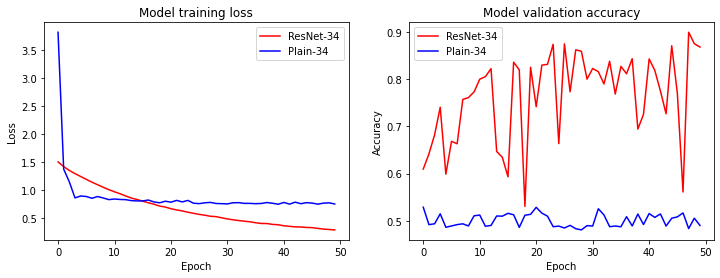

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

## ResNet-50과 Plain-50 비교

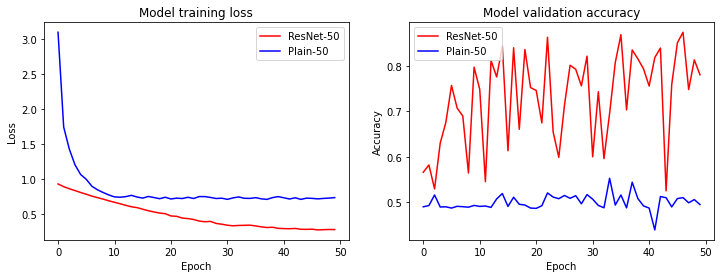

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_50['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_50['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

## 전체 비교

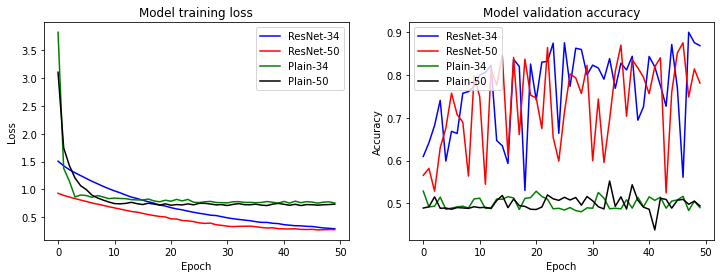

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'g')
plt.plot(history_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'g')
plt.plot(history_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

|모델||
|:---:|:---:|
|ResNet-34와<br>Plain-34|![](https://images.velog.io/images/seona056/post/99a973ed-1027-4a65-85f3-6eb9ab90c13b/image.png)|
|ResNet-50와<br>Plain-50|![](https://images.velog.io/images/seona056/post/df50ef02-b791-47a9-a3f5-7407e6965e5e/image.png)|
|전체 비교|![](https://images.velog.io/images/seona056/post/9f91f55d-a75b-4e52-baf0-ac0fb58d1c9b/image.png)|
|Anderew Ng의 강의<br>Plain과 ResNet의 loss비교|![](https://images.velog.io/images/seona056/post/2ae61b6d-f2b0-4624-a426-14ceaf74d0a0/Untitled.png)|

<br>

- 모든 accuracy는 안정되지 않고 많은 차이가 난다. 하지만 상대적인 비교를 하자면, Plain보다 ResNet의 accuracy가 높다.
- loss 그래프는 예전에 `노드 22`에서 [레즈넷의 skip connection에 대한 영상](https://youtu.be/ZILIbUvp5lk) (**Andrew Ng 교수**)에서 설명했던 그래프와 완전히 같은 그래프가 나와서 놀랐다.
- 영상의 설명에 따르면, 이론적으로는 레이어가 깊어질 수록 loss가 작아져야하는데 실제로는 레이어가 깊어질 수록 어느순간 다시 loss가 증가하는 모양새가 된다고 한다.
- 이런 문제점을 보완하고자 skip connection의 개념이 나왔고, 레즈넷은 이론과 같은 그래프(레이어가 깊어질수록 loss가 감소)를 기록한다는 설명이었다.
- 지금 구현한 레즈넷과 plain network의 loss 비교 그래프에서 그 강의 영상과 완전히 같은 모양의 그래프가 나와서 사진을 캡쳐하여 첨부하였다. 신기하다. 🎃🎊🎉


# 회고

## 공부한 내용

### 1. 가중치 초기화

**cs231n에 나온 ResNet**

![](https://images.velog.io/images/seona056/post/8c8fbd8b-801e-4c3b-9947-1c95fcdc8ebe/image.png)

<br>

- 위의 슬라이드를 보고 xaiver 초기화를 사용한 건가 했는데, `he 초기화`를 사용한 것이었다.
- xavier 초기화를 **Kaiming He**가 2015년에 개선한 것.
- xavier 초기화는 sigmoid나 tanh 등의 비선형 함수에서 효과적이다. 
- 하지만 ReLU 에서는 gradient vanishing 현상이 나타남
- ReLU에서는 **he 초기화가 효과적**이라고 알려져 있다.
- resnet에서는 ReLU를 사용하므로 he 초기화를 사용하는게 맞는 듯
- 참고로 **Kaiming He**는 resnet 논문 저자이다.

<br>

여담이지만, 아래 블로그를 보니 xavier 초기화의 제 2 저자가 **Yoshua Bengio**라고 한다.<br>
요즘 EBS에서 하는 **`그레이트 마인즈`**라는 강의 시리즈가 있는데, <u>최근에 요슈아 벤지오의 강의 시리즈가 방영중</u>이다.<br>
교양 정도의 내용이긴 하지만, 한번 들어보는 것을 추천!<br>
(웬만하면 다른 분야의 강연도 들어보면 어떨까...! **현 시대 각 분야의 최고 권위자들의 강연**이다)

<br>

- 참고 블로그 1 : https://reniew.github.io/13/
- 참고 블로그 2 : https://buomsoo-kim.github.io/keras/2018/04/22/Easy-deep-learning-with-Keras-4.md/

 ### 2. 💾**residual block, bottleneck**  (**`[E-09]`** 노드의 회고를 참고)

- ResNet-18,34는 왼쪽 residual block을 사용하고, ResNet-50 부터는 오른쪽 BottleNeck을 사용

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fcjoceg%2Fbtq0ulXxaaM%2FdkAS3aQHHg6BU4ReLgxsFk%2Fimg.png)

- 기본 residual block은 `3x3` 필터를 사용하는 **conv2D**를 두 번 사용한 뒤, `relu`이전에 output과 입력을 더해준다.
- BottleNeck은 `1x1` → `3x3` → `1x1` 필터를 사용하는 **conv2D**를 3번 사용한 뒤 output과 입력을 더해주는 방식을 사용한다.

<br>

>**❓bottleneck을 사용하는 이유❓**<br><br>


### 3. 📁 **L2(Ridge) 규제란**❓ (**`[E-09]`** 노드의 회고를 참고)

<br>

- **가중치 규제(Weight Regularization)**
    - 가중치 규제는 개별 가중치 값을 제한하여 복잡한 모델을 좀 더 간단하게 하는 방법 
    - 복잡한 모델은 많은 수의 매개변수를 가진 모델로, <u>과적합이 일어날 가능성</u>이 크므로 가중치를 규제해 준다.

<br>

- L2 규제는 모든 가중치 $w$의 제곱합을 비용 함수(cost function)에 추가한다.
- 기존의 비용 함수에 모든 가중치에 대해서 $\lambda\frac{1}{2}|w|^{2}$를 더한 값을 비용 함수로 한다.

- $cost(W, b)=\frac{1}{m}\sum_{i}^{m}L(\hat{y_{i}}, y_{i})+\lambda\frac{1}{2}|w|^{2}$

- $\lambda$는 **규제의 강도**를 정하는 하이퍼 파라미터이다. <u>0에 가까울수록 정규화의 효과는 사라진다.</u>
- 비용 함수를 최소화하기 위해서는 가중치 $w$들의 값이 작아져야한다.

### 4. FC layer와 GAP

[2/4 DEEP ML 시간에 발표](https://www.notion.so/2-4-41a00cac34d543ee9fdfd1fae1068496)했던 ResNet 내용 중에서, 요즘은 FC layer보다 **GAP을 더 많이 사용하는 추세**라는 내용이 생각나서 다시 발표자료를 확인해 봄.<br>
그 당시에 발표는 했지만, 잘 이해하지 못했어서 다시 복습을 해 보았다.

<br>

![](https://images.velog.io/images/seona056/post/6e7e2f81-d6b1-4e9f-a513-168b7a699b33/DeepML2%20(2).png)

<br>

**4-1) fully connected layer**
- 기존 FC Layer를 사용한 분류에서는 Flatten Layer를 이용해서 입력받은 값을 굉장히 긴 하나의 벡터로 만든 다음, 그 벡터를 FC Layer에 넣는 방식으로 하나하나 매핑해서 클래스를 분류했다. 
- 이 과정에서 공간적 정보도 많이 잃어버리는데다가, 굉장히 많은 파라미터, 즉 가중치가 많이 필요하고, VGGNet의 경우 이 부분이 **전체 계산량의 85%를 차지**했다. 
- 컨볼루션 레이어를 아무리 쌓아도 FC Layer 하나를 못 따라갈 정도

<br>

**4-2) Global Average Pooling**
- 우선 분류할 클래스 수만큼 feature map을 마지막에 생성
- 그 feature map 안에 있는 특징값들의 평균을 구해서 각각의 출력 노드에 바로 입력하는 방식이다.
- 위 그림을 보면 보라, 초록, 파랑 3개의 feature map이 있는데 각각의 평균을 구해서 하나로 만들어서 출력 노드에 입력
- 이 방식은 85%의 가중치를 없애므로 계산량과 모델의 무게가 줄어들고, 파라미터가 줄어드니까 덩달아 **오버피팅 방지 효과**도 있다.
- 그리고 이 방법이 정보량 손실이 많이 될 것 같고, 실제로도 그렇다.
- 이미지의 모든 값을 평균내버리는 건데, 정보를 잃지 않을 수 없다. 그러나 그럼에도 불구하고 성능이 좋다고 함
- 더 자세히 말하면, GAP 연산은 채널 별로 평균을 낼 뿐이고, 평균을 통해 얻은 클래스 개수만큼의 1차원 벡터와 클래스 라벨로 loss를 계산해 업데이트 했을 때, <u>GAP 연산의 결과가 아닌</u> **GAP 연산을 거치기 전의 컨볼루션 필터(커널)들**을 학습시킨다. 
- 이때 역전파를 통해 loss를 업데이트하면서 해당 컨볼루션 필터들은 이미지의 특징을 더 잘 잡도록 훈련될 것이며, 그 부분이 response가 된다. 
- 이 response 덕에 GAP 연산을 적용하면 Layer에 비해 location 정보를 상대적으로 덜 잃는 것</u>으로 볼 수 있다.
- 또한, <u>FC Layer에 입력되는 노드 수 같은 걸 계산할 필요도 없어진다.</u> 
- 그리고 각 채널의 평균값을 계산하므로 해당 이미지의 **global context** 정보를 얻을 수 있다는 장점도 있다.

<br>

**GAP의 장점 요약**
1. Location 정보를 FC Layer보다 적게 잃는다.
2. 파라미터를 차지하지 않아 계산 속도가 빠르다.
3. 마찬가지로 파라미터가 많아지지 않기 때문에 오버피팅을 방지한다.
4. feature map 안의 값들의 평균을 사용하기 때문에 global context 정보를 가진다

<br>

- 참고 블로그 : https://mole-starseeker.tistory.com/66

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

## Thanks to

강남 경원 퍼실님 감사드립니다🙏<br>
`summary()`에서 <u>'입력이 텐서가 아니다'</u> 라는 이상한 에러메세지가 떴는데, `build_resnet()`의 코드를 도와주셨습니다!